
### Dataset

In this homework, we will use the Car price dataset.  We'll keep working with the `MSRP` variable, and we'll transform it to a classification task. 

### Features

For the rest of the homework, you'll need to use only these columns: 

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`

### Data preparation

* Select only the features from above and transform their names using next line: 
  ```
  data.columns = data.columns.str.replace(' ', '_').str.lower()
  ```
* Fill in the missing values of the selected features with 0. 
* Rename `MSRP` variable to `price`. 


In [1]:
import matplotlib.pyplot as mp
import seaborn as sb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score

In [2]:
car_df=pd.read_csv("datasets/data.csv")
features_to_keep=['Make', 
                  'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg']
data_features=car_df[features_to_keep]
data_features.columns = data_features.columns.str.replace(' ', '_').str.lower()
data_features=data_features.fillna(0)
data_features['price']=car_df["MSRP"]

## Question 1

What is the most frequent observation (mode) for the column `transmission_type`?

- `AUTOMATIC`


In [3]:
data_features['transmission_type'].value_counts()

transmission_type
AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: count, dtype: int64

In [4]:
data_features['transmission_type'].mode()

0    AUTOMATIC
Name: transmission_type, dtype: object

## Question 2
Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your dataset. 
In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?
- `highway_mpg` and `city_mpg`


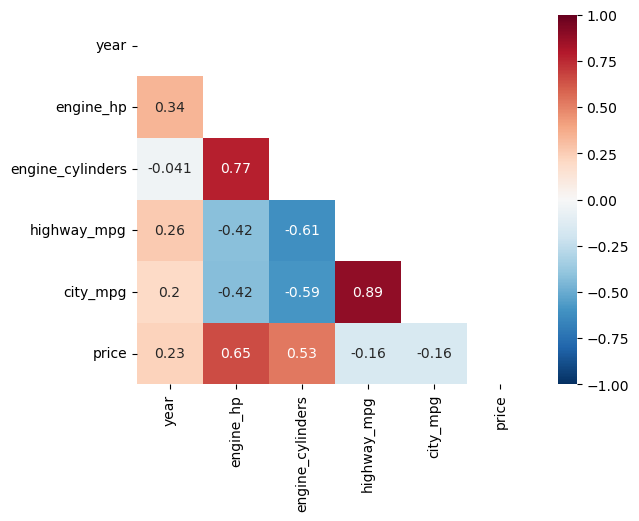

In [5]:
numeric_features=data_features.select_dtypes(include='number')
mask = np.triu(np.ones_like(numeric_features.corr()))
dataplot = sb.heatmap(numeric_features.corr(), cmap='RdBu_r', mask=mask, annot=True, vmin=-1, vmax=1)
mp.show()

### Make `price` binary

* Now we need to turn the `price` variable from numeric into a binary format.
* Let's create a variable `above_average` which is `1` if the `price` is above its mean value and `0` otherwise.

In [6]:
mean_price=np.mean(data_features["price"])
data_features["binary_price"]=data_features["price"] > mean_price

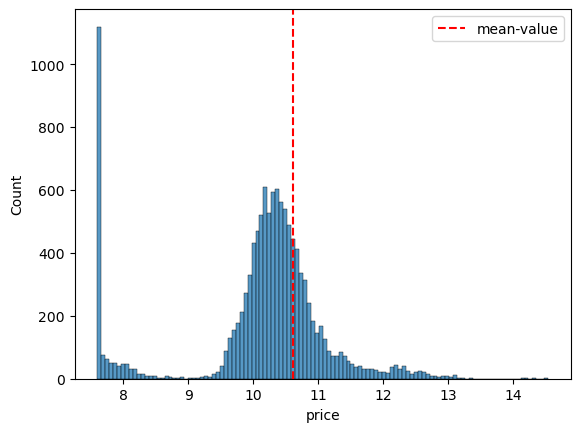

In [7]:
sb.histplot(np.log(data_features["price"]),kde=False)
mp.axvline(x=np.log(np.mean(data_features["price"])), 
            color='red', 
            linestyle='--',
            label='mean-value')
mp.legend()
mp.show()


### Split the data

* Split your data in train/val/test sets with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
* Make sure that the target value (`above_average`) is not in your dataframe.

obs:rename above_average to price_binary

In [8]:
X_train, X_test = train_test_split(data_features, test_size=0.2, train_size=.8, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.25, train_size=.75, random_state=42)

In [9]:
(len(data_features)*.2)-len(X_test), (len(data_features)*.2)-len(X_val), (len(data_features)*.6)-len(X_train)

(-0.1999999999998181, -0.1999999999998181, 0.3999999999996362)

In [10]:
features_to_keep=['make', 'model', 'year', 'engine_hp', 'engine_cylinders', 'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']
y_train=X_train["binary_price"]
X_train=X_train[features_to_keep]

y_val=X_val["binary_price"]
X_val=X_val[features_to_keep]

y_test=X_test["binary_price"]
X_test=X_test[features_to_keep]

In [11]:
X_train.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg'],
      dtype='object')

In [12]:
X_val.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg'],
      dtype='object')

In [13]:
X_test.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg'],
      dtype='object')

## Question 3

* Calculate the mutual information score between `above_average` and other categorical variables in our dataset. 
  Use the training set only.
* Round the scores to 2 decimals using `round(score, 2)`.

Which of these variables has the lowest mutual information score?

- `model`


In [14]:
categorial_X_train=X_train.select_dtypes(exclude='number')
for i in categorial_X_train.columns:
    mi_score=mutual_info_score(y_train, categorial_X_train[i])
    print(str(i) + ":" + str(np.round(mi_score, 2)))


make:0.24
model:0.46
transmission_type:0.02
vehicle_style:0.08


## Question 4

* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding. 
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?
- 0.95


In [15]:
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
     X_train.select_dtypes(exclude="number").columns),
    remainder='passthrough')

transformed = transformer.fit_transform(X_train)
X_train_transformed = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [16]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train_transformed, y_train)


LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [17]:
X_val_transformed= pd.DataFrame(transformer.transform(X_val),
                                  columns=transformer.get_feature_names_out())
predictions_val = model.predict(X_val_transformed)
acc_val_ref=accuracy_score(predictions_val, y_val)

In [18]:
np.around(acc_val_ref, 2)

0.94

## Question 5

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 

Which of following feature has the smallest difference?

- `transmission_type` if difference in validation set
- `city_mpg` if difference in test set

> **Note**: the difference doesn't have to be positive



In [19]:
X_test_transformed= pd.DataFrame(transformer.transform(X_test),
                                  columns=transformer.get_feature_names_out())
    
predictions_test = model.predict(X_test_transformed)
acc_test_ref=accuracy_score(predictions_test, y_test)

In [37]:
res_lis=[]
for i in X_train.columns:
    temp_train=X_train.drop([i], axis=1)
    temp_val=X_val.drop([i], axis=1)
    temp_test=X_test.drop([i], axis=1)

    transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
    temp_train.select_dtypes(exclude="number").columns),
    remainder='passthrough')

    transformed = transformer.fit_transform(temp_train)
    X_train_transformed = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train_transformed, y_train)

    X_val_transformed= pd.DataFrame(transformer.transform(temp_val),
                                  columns=transformer.get_feature_names_out())
    
    X_test_transformed= pd.DataFrame(transformer.transform(temp_test),
                                 columns=transformer.get_feature_names_out())
    
    predictions_val = model.predict(X_val_transformed)
    predictions_test = model.predict(X_test_transformed)

    acc_val=accuracy_score(predictions_val, y_val) 
    acc_test=accuracy_score(predictions_test, y_test)
    
    diff_val=np.absolute(acc_val_ref - acc_val)
    diff_test=np.absolute(acc_test_ref - acc_test)
    
    res_lis.append((i, diff_val, diff_test))
 


In [40]:
df_res=pd.DataFrame.from_records(res_lis)
df_res.columns=['feature', 'dif_validation', 'dif_test']
df_res

,feature,dif_validation,dif_test
0,make,0.005875,0.005875
1,model,0.023500,0.017625
2,year,0.007973,0.012589
3,engine_hp,0.009232,0.007134
4,engine_cylinders,0.007134,0.012589
5,transmission_type,0.005455,0.009232
6,vehicle_style,0.006714,0.001679
7,highway_mpg,0.001679,0.002518
8,city_mpg,0.007134,0.004616


In [46]:
mask=df_res['feature'].isin(['year', 'engine_hp', 'transmission_type', 'city_mpg'])
df_res[mask]

,feature,dif_validation,dif_test
2,year,0.007973,0.012589
3,engine_hp,0.009232,0.007134
5,transmission_type,0.005455,0.009232
8,city_mpg,0.007134,0.004616


## Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn.
* We'll need to use the original column `price`. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model on the training data with a solver `'sag'`. Set the seed to `42`.
* This model also has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`.
* Round your RMSE scores to 3 decimal digits.

Which of these alphas leads to the best RMSE on the validation set?

- 0
- 0.01
- 0.1
- 1
- 10

> **Note**: If there are multiple options, select the smallest `alpha`.

